# Alzheimer & MCI DeepLearning(CNN) Classifier
- ADNI MRI 이미지로 알츠하이머와 경도인지장애를 분류하는 딥러닝 프로젝트
- 데이터 출처
  - 메타데이터 : https://ida.loni.usc.edu/
  - MRI이미지 : https://www.kaggle.com/datasets/katalniraj/adni-extracted-axial
- 저작권에 의해 데이터는 깃허브에 업로드 하지 않았음

## Part1. EDA(탐색적 데이터 분석) & Dashboard 데이터 생성
- 본 작업은 로컬환경(VScode)에서 진행되었음.
- 로컬 가상 환경(Conda)
  - OS : Windows11
  - Python version : 3.9
  - Packages : requirments.txt로 설치하여 진행하였음
  - Tensorflow version : 2.7

In [20]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import plotly.express as plex
import plotly.graph_objects as go

### 1-1. 메타데이터 DataFrame 생성

- 데이터 불러오기

In [2]:
df0 = pd.read_csv('metadata/ADNI-Baseline-meta.csv')
df0.sample(5, random_state=42)

,Subject ID,Sex,Research Group,Age,Description
907,067_S_0607,F,MCI,78.3,localizer
617,031_S_0830,M,MCI,70.9,B1-calibration Body
1386,133_S_0792,M,MCI,73.7,Circle Scout
941,067_S_1253,F,AD,62.8,localizer
303,018_S_0450,M,MCI,68.7,MPRAGE


- 필요없는 Column ("Description") 제외

In [3]:
df1 = df0.iloc[:,:-1]
df1.sample(5, random_state=42)

,Subject ID,Sex,Research Group,Age
907,067_S_0607,F,MCI,78.3
617,031_S_0830,M,MCI,70.9
1386,133_S_0792,M,MCI,73.7
941,067_S_1253,F,AD,62.8
303,018_S_0450,M,MCI,68.7


- Shape 확인

In [4]:
df1.shape

(1512, 4)

- Column 이름 변경 및 결측치 확인

In [7]:
COLUMNS = ['ID', 'Gender', 'Group', 'Age']
df1.columns = COLUMNS
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      1512 non-null   object 
 1   Gender  1512 non-null   object 
 2   Group   1512 non-null   object 
 3   Age     1512 non-null   float64
dtypes: float64(1), object(3)
memory usage: 47.4+ KB


- 중복치 확인 및 제거

In [8]:
df1.duplicated(subset=COLUMNS, keep=False).sum()

1512

In [9]:
# 제거
df2 = df1.copy()
df2 = df2.drop_duplicates(subset=COLUMNS, keep='first')
df2.shape

(187, 4)

- Age column 정수형으로 변환

In [10]:
df3 = df2.copy()
df3.Age = df3.Age.astype(int)
df3.head()

,ID,Gender,Group,Age
0,002_S_0413,F,CN,76
7,002_S_0559,M,CN,79
16,002_S_0729,F,MCI,65
23,002_S_0816,M,AD,71
29,002_S_0954,F,MCI,69


- Age Range(나이대) column 추가

In [15]:
age_range = []
for i in df3.Age:
    if 50 <= i < 60:
        age_range.append('50s')
    elif 60 <= i < 70:
        age_range.append('60s')
    elif 70 <= i < 80:
        age_range.append('70s')
    elif 80 <= i < 90:
        age_range.append('80s')
    elif 90 <= i < 100:
        age_range.append('90s')
df4 = df3.copy()
df4['Age_Range'] = age_range
df4.head()

,ID,Gender,Group,Age,Age_Range
0,002_S_0413,F,CN,76,70s
7,002_S_0559,M,CN,79,70s
16,002_S_0729,F,MCI,65,60s
23,002_S_0816,M,AD,71,70s
29,002_S_0954,F,MCI,69,60s


### 1-2. ImageData Count 및 Merge DataFrames

- 이미지 데이터 파일명 리스트 생성

In [16]:
#파일 경로 지정
base_dir = "./imagedata/Axial/"

CN_dir = base_dir + "CN"
MCI_dir = base_dir + "MCI"
AD_dir = base_dir + "AD"

In [19]:
# CN 폴더 이미지 파일명 리스트
CN_files = os.listdir(CN_dir)
CN_files[:5]

['CN002_S_0413a084.png',
 'CN002_S_0413a085.png',
 'CN002_S_0413a086.png',
 'CN002_S_0413a087.png',
 'CN002_S_0413a088.png']

In [45]:
# 정규식을 이용해 subject_ID만 추출해보기
CN_extracted = []
for i in CN_files:
    ext = re.search("((\d{3})_(\D)_(\d{4}))",i)
    CN_extracted.append(ext.group())
CN_extracted[:5]

['002_S_0413', '002_S_0413', '002_S_0413', '002_S_0413', '002_S_0413']

In [48]:
# Subject_ID만 추출하는 함수 정의
def filename_to_ID(dir):
    filenames = os.listdir(dir)
    
    extracted_list = []
    
    for f in filenames:
        ex = re.search("((\d{3})_(\D)_(\d{4}))",f)
        extracted_list.append(ex.group())
    
    return extracted_list

In [72]:
# Subject_ID 추출
CN_img_id = filename_to_ID(CN_dir)
MCI_img_id = filename_to_ID(MCI_dir)
AD_img_id = filename_to_ID(AD_dir)

print('첫번째 이미지 ID')
print("CN :", CN_img_id[0])
print("MCI :", MCI_img_id[0])
print("AD :", AD_img_id[0])
print('---')
print('리스트 길이')
print("CN :", len(CN_img_id))
print("MCI :", len(MCI_img_id))
print("AD :", len(AD_img_id))

첫번째 이미지 ID
CN : 002_S_0413
MCI : 002_S_0729
AD : 002_S_0816
---
리스트 길이
CN : 1440
MCI : 2590
AD : 1124


- 이미지 데이터 DataFrame 생성

In [73]:
# 리스트 결합
Image_IDs = CN_img_id+MCI_img_id+AD_img_id
len(Image_IDs)

5154

In [74]:
# Series 생성
image_se = pd.Series(Image_IDs, name='ID')
image_se

0       002_S_0413
1       002_S_0413
2       002_S_0413
3       002_S_0413
4       002_S_0413
           ...    
5149    136_S_0426
5150    136_S_0426
5151    136_S_0426
5152    136_S_0426
5153    136_S_0426
Name: ID, Length: 5154, dtype: object

In [78]:
# ID별 Count
image_count = image_se.value_counts().reset_index(drop=False)
image_count.columns = ['ID','Images']
image_count.sample(5,random_state=42)

,ID,Images
73,027_S_1385,30
18,023_S_0855,61
117,067_S_0812,19
78,027_S_0835,29
76,016_S_1117,29


- Merge Data

In [83]:
df5 = pd.merge(
    left=df4,
    right=image_count,
    how='left',
    on='ID'
)
display(df5.head())
df5.info()

,ID,Gender,Group,Age,Age_Range,Images
0,002_S_0413,F,CN,76,70s,65.0
1,002_S_0559,M,CN,79,70s,46.0
2,002_S_0729,F,MCI,65,60s,82.0
3,002_S_0816,M,AD,71,70s,59.0
4,002_S_0954,F,MCI,69,60s,40.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 186
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         187 non-null    object 
 1   Gender     187 non-null    object 
 2   Group      187 non-null    object 
 3   Age        187 non-null    int32  
 4   Age_Range  187 non-null    object 
 5   Images     149 non-null    float64
dtypes: float64(1), int32(1), object(4)
memory usage: 9.5+ KB


In [87]:
# Images column Nan 값 0으로 대체 후 정수형으로 변환
df6 = df5.copy()
df6 = df6.fillna(0)
df6.Images = df6.Images.astype(int)
display(df6.head())
df6.info()

,ID,Gender,Group,Age,Age_Range,Images
0,002_S_0413,F,CN,76,70s,65
1,002_S_0559,M,CN,79,70s,46
2,002_S_0729,F,MCI,65,60s,82
3,002_S_0816,M,AD,71,70s,59
4,002_S_0954,F,MCI,69,60s,40


<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 186
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         187 non-null    object
 1   Gender     187 non-null    object
 2   Group      187 non-null    object
 3   Age        187 non-null    int32 
 4   Age_Range  187 non-null    object
 5   Images     187 non-null    int32 
dtypes: int32(2), object(4)
memory usage: 8.8+ KB


- DataFrame 저장 (Dashboard용 Data로 활용할 예정)

In [88]:
df6.to_csv('metadata/ADNI-Baseline-dashboard.csv', index=False)

### 1-3. metadata EDA (plotly)

- 깃허브 업로드를 위해 renderer를 png로 설정

In [89]:
%pip show kaleido

Name: kaleido
Version: 0.2.1
Summary: Static image export for web-based visualization libraries with zero dependencies
Home-page: UNKNOWN
Author: Jon Mease
Author-email: jon@plotly.com
License: MIT
Location: d:\anaconda3_envs\alz-mci\lib\site-packages
Requires: 
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [91]:
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'vscode'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [92]:
pio.renderers.default = 'png'

- 데이터 불러오기

In [93]:
adni = pd.read_csv('metadata/ADNI-Baseline-dashboard.csv')
adni.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         187 non-null    object
 1   Gender     187 non-null    object
 2   Group      187 non-null    object
 3   Age        187 non-null    int64 
 4   Age_Range  187 non-null    object
 5   Images     187 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 8.9+ KB


#### Research Group

- Group by "Research Group" (Subjects)

In [94]:
group_count = adni.groupby(['Group'], as_index=False)['ID'].count()
group_count

,Group,ID
0,AD,40
1,CN,60
2,MCI,87


In [95]:
# reindex
group_count_index = [1,2,0]
group_count_sort = group_count.reindex(group_count_index, axis=0).reset_index(drop=True)
group_count_sort

,Group,ID
0,CN,60
1,MCI,87
2,AD,40


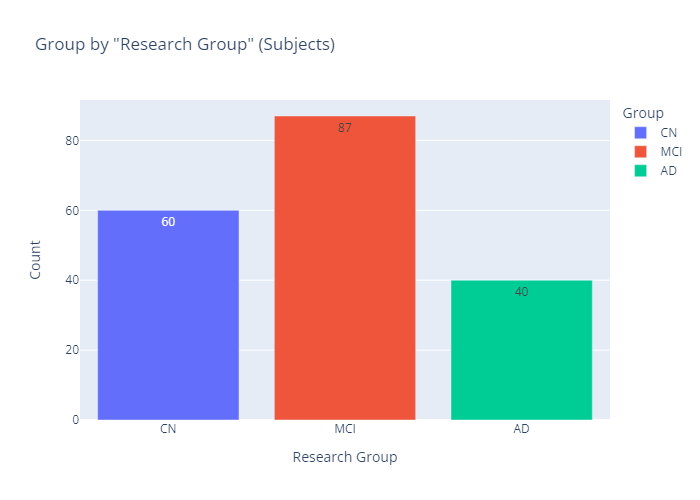

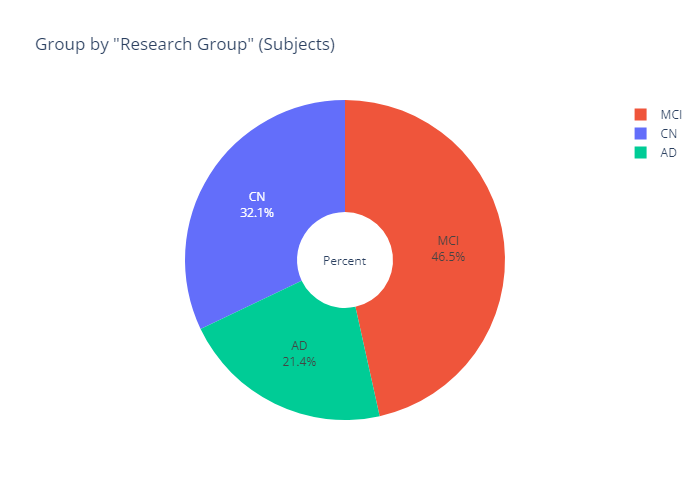

In [98]:
group_count_title = 'Group by "Research Group" (Subjects)'
group_count_bar = plex.bar(data_frame=group_count_sort,
                           x='Group', y='ID', color='Group',
                           text_auto=True, title=group_count_title)
group_count_bar.update_layout(xaxis_title='Research Group',
                              yaxis_title='Count')
group_count_bar.show()

group_count_pie = plex.pie(data_frame=group_count_sort, hole=0.3,
                           values='ID', names='Group', color='Group',
                           title=group_count_title)
group_count_pie.update_traces(textposition='inside', textinfo='percent+label')
group_count_pie.update_layout(annotations=[dict(text='Percent', showarrow=False)])
group_count_pie.show()

- Group by "Research Group" (Images)

In [101]:
group_images = adni.groupby(['Group'], as_index=False)['Images'].sum()
group_images

,Group,Images
0,AD,1124
1,CN,1440
2,MCI,2590


In [102]:
# reindex
group_images_index = [1,2,0]
group_images_sort = group_images.reindex(group_images_index, axis=0).reset_index(drop=True)
group_images_sort

,Group,Images
0,CN,1440
1,MCI,2590
2,AD,1124


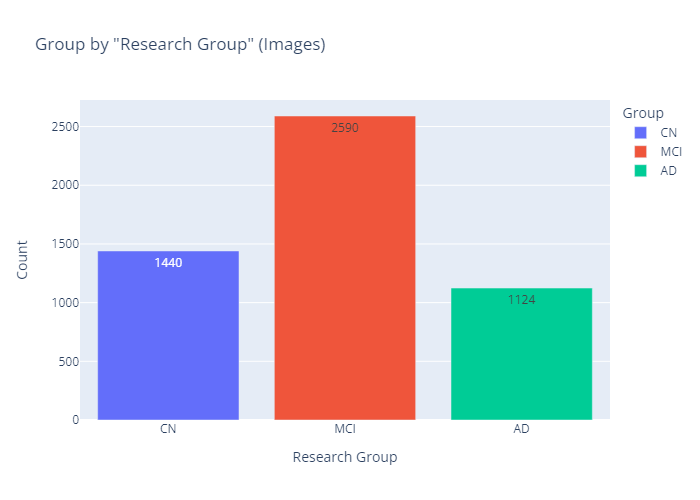

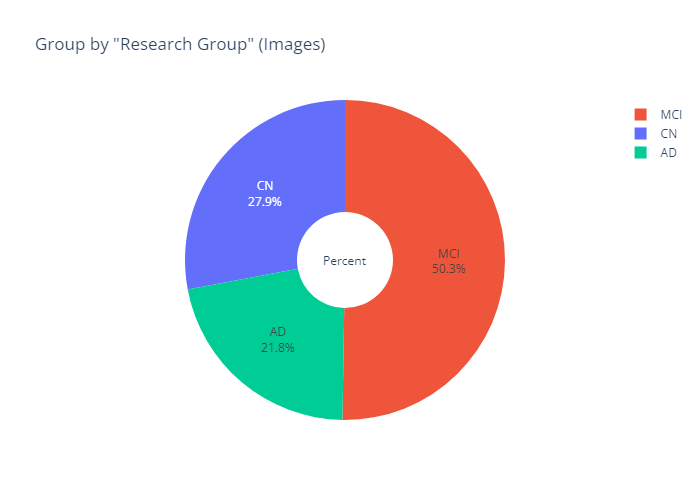

In [104]:
group_images_title = 'Group by "Research Group" (Images)'
group_images_bar = plex.bar(data_frame=group_images_sort,
                           x='Group', y='Images', color='Group',
                           text_auto=True, title=group_images_title)
group_images_bar.update_layout(xaxis_title='Research Group',
                              yaxis_title='Count')
group_images_bar.show()

group_images_pie = plex.pie(data_frame=group_images_sort, hole=0.3,
                           values='Images', names='Group', color='Group',
                           title=group_images_title)
group_images_pie.update_traces(textposition='inside', textinfo='percent+label')
group_images_pie.update_layout(annotations=[dict(text='Percent', showarrow=False)])
group_images_pie.show()

- Group by "Gender"

In [105]:
group_gender = adni.groupby(['Gender'], as_index=False)['ID'].count()
group_gender

,Gender,ID
0,F,96
1,M,91


In [106]:
fix_gender = group_gender.copy()
fix_gender.Gender = fix_gender.Gender.replace({'F':'Female', 'M':'Male'})
fix_gender

,Gender,ID
0,Female,96
1,Male,91


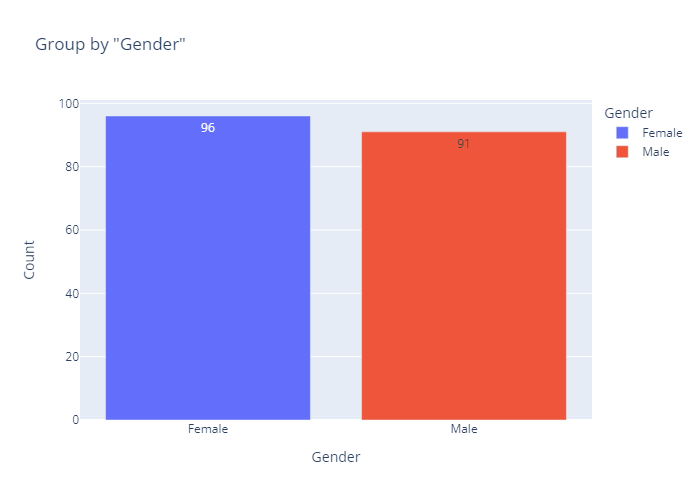

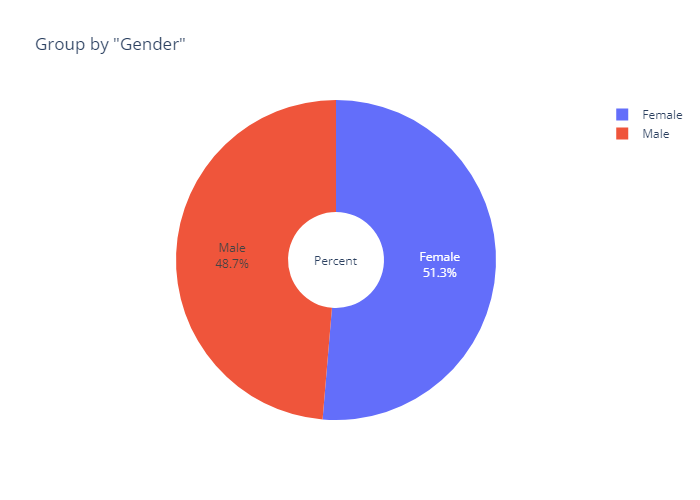

In [107]:
gender_title = 'Group by "Gender"'
gender_bar = plex.bar(data_frame=fix_gender, x='Gender', y='ID', color='Gender',
                   text_auto=True,title=gender_title)
gender_bar.update_layout(xaxis_title = 'Gender', yaxis_title = 'Count')
gender_bar.show()

gender_pie = plex.pie(data_frame=fix_gender, hole=0.3,
                   values='ID', names='Gender', color='Gender',
                   title=gender_title)
gender_pie.update_traces(textposition='inside', textinfo='percent+label')
gender_pie.update_layout(annotations=[dict(text='Percent',showarrow=False)])
gender_pie.show()

- Group by "Reserch Group" & "Gender"

In [108]:
group_and_gender = adni.groupby(['Group','Gender'], as_index=False)['ID'].count()
group_and_gender

,Group,Gender,ID
0,AD,F,25
1,AD,M,15
2,CN,F,38
3,CN,M,22
4,MCI,F,33
5,MCI,M,54


In [110]:
gg_list = [2,3,4,5,0,1]
sort_gg = group_and_gender.reindex(gg_list, axis=0).reset_index(drop=True)
fix_gg = sort_gg.copy()
fix_gg.Gender = fix_gg.Gender.replace({'F':'Female', 'M':'Male'})
fix_gg.columns = ['Group','Gender', 'Counts']
fix_gg

,Group,Gender,Counts
0,CN,Female,38
1,CN,Male,22
2,MCI,Female,33
3,MCI,Male,54
4,AD,Female,25
5,AD,Male,15


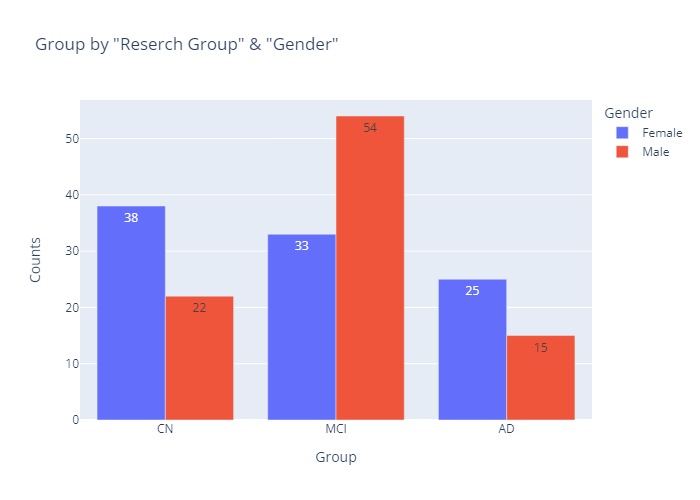

In [111]:
gg_bar = plex.bar(data_frame=fix_gg,
                  x='Group',y='Counts',color='Gender',
                  title='Group by "Reserch Group" & "Gender"',
                  text_auto=True, barmode='group')
gg_bar.show()

- Histogram of "Age"

In [112]:
# 범위 확인
np.min(adni.Age), np.max(adni.Age)

(55, 91)

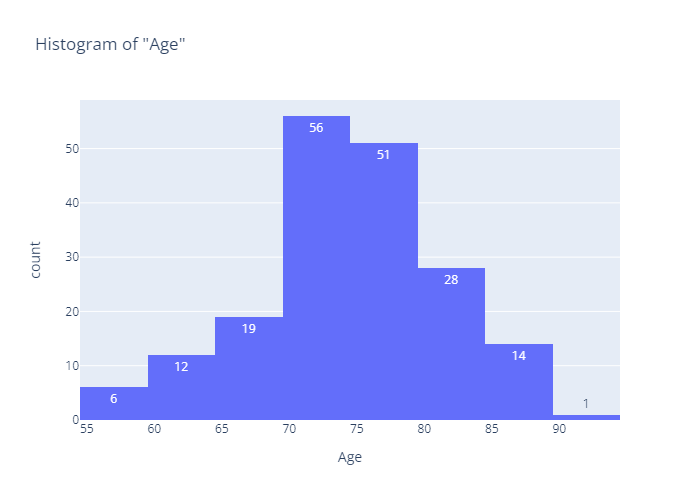

In [113]:
age_hist = plex.histogram(data_frame=adni, x='Age', nbins=8,
                          title='Histogram of "Age"',text_auto=True)
age_hist.update_xaxes(dtick=5)
age_hist.show()

- Histogram of "Age" & "Gender"

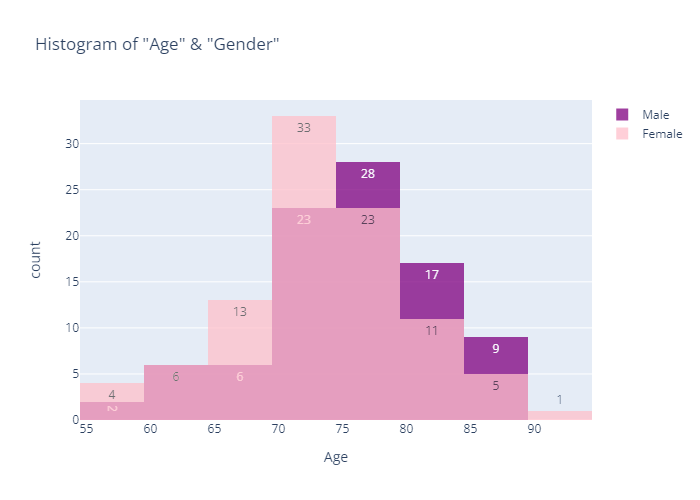

In [115]:
age_male = adni.query('Gender == "M"')
age_female = adni.query('Gender == "F"')

age_overlaid = go.Figure()
age_overlaid.add_trace(go.Histogram(x=age_male.Age, name='Male',
                       marker_color='purple',texttemplate="%{y}"))
age_overlaid.add_trace(go.Histogram(x=age_female.Age, name='Female',
                       marker_color='pink',texttemplate="%{y}"))

age_overlaid.update_layout(barmode='overlay',
                           title_text='Histogram of "Age" & "Gender"',
                           xaxis_title_text="Age",
                           yaxis_title_text="count")
age_overlaid.update_traces(opacity=0.75)
age_overlaid.update_xaxes(dtick=5)
age_overlaid.show()

- Group by "Age Range"

In [116]:
group_ar = adni.groupby(['Age_Range'], as_index=False)['ID'].count()
group_ar.columns = ['Age_Range', 'Counts']
group_ar

,Age_Range,Counts
0,50s,6
1,60s,31
2,70s,107
3,80s,42
4,90s,1


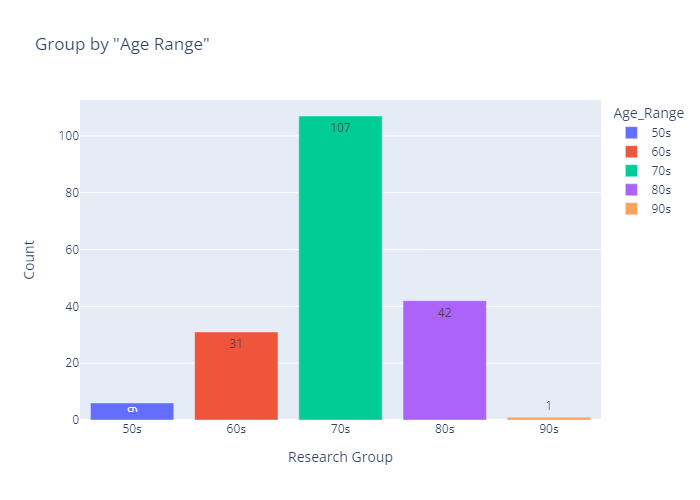

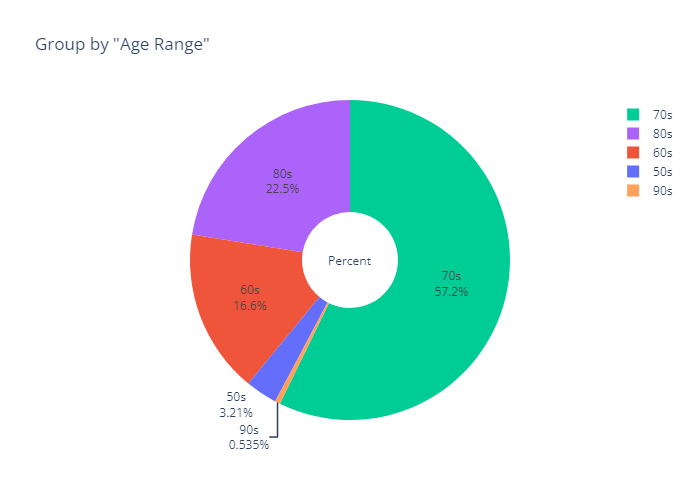

In [120]:
ar_title = 'Group by "Age Range"'
ar_bar = plex.bar(data_frame=group_ar, x='Age_Range', y='Counts', color='Age_Range',
                   text_auto=True,title=ar_title)
ar_bar.update_layout(xaxis_title = 'Research Group', yaxis_title = 'Count')
ar_bar.show()

ar_pie = plex.pie(data_frame=group_ar, hole=0.3,
                   values='Counts', names='Age_Range', color='Age_Range',
                   title=ar_title)
ar_pie.update_traces(textinfo='percent+label')
ar_pie.update_layout(annotations=[dict(text='Percent',showarrow=False)])
ar_pie.show()

- Group by "Age Range" & "Reserch Group"

In [121]:
group_ag = adni.groupby(['Age_Range','Group'], as_index=False)['ID'].count()
group_ag

,Age_Range,Group,ID
0,50s,AD,2
1,50s,MCI,4
2,60s,AD,10
3,60s,CN,1
4,60s,MCI,20
5,70s,AD,17
6,70s,CN,50
7,70s,MCI,40
8,80s,AD,10
9,80s,CN,9


In [122]:
# 그래프 순서를 맞추기위해 행 추가
group_ag.loc[12] = ['50s', 'CN', 0]
group_ag

,Age_Range,Group,ID
0,50s,AD,2
1,50s,MCI,4
2,60s,AD,10
3,60s,CN,1
4,60s,MCI,20
5,70s,AD,17
6,70s,CN,50
7,70s,MCI,40
8,80s,AD,10
9,80s,CN,9


In [123]:
# reindex
ag_list = [12,1,0,3,4,2,6,7,5,9,10,8,11]
sort_ag = group_ag.reindex(ag_list, axis=0).reset_index(drop=True)
sort_ag.columns = ['Age_Range', 'Group', 'Counts']
sort_ag

,Age_Range,Group,Counts
0,50s,CN,0
1,50s,MCI,4
2,50s,AD,2
3,60s,CN,1
4,60s,MCI,20
5,60s,AD,10
6,70s,CN,50
7,70s,MCI,40
8,70s,AD,17
9,80s,CN,9


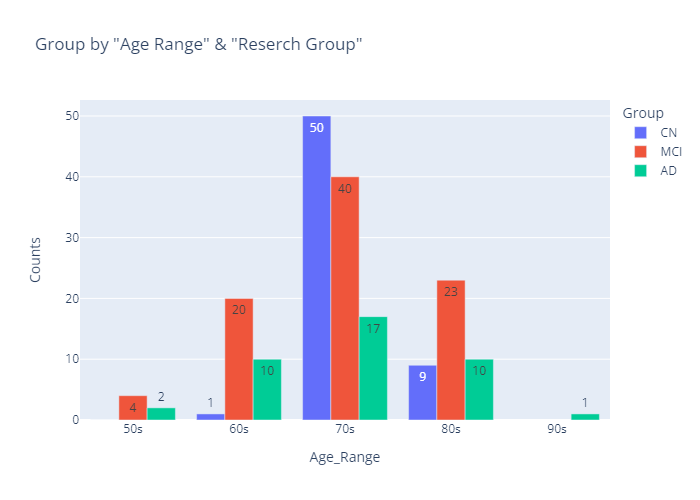

In [124]:
ag_bar = plex.bar(data_frame=sort_ag,
                  x='Age_Range',y='Counts',color='Group',
                  title='Group by "Age Range" & "Reserch Group"',
                  text_auto=True,barmode='group')
ag_bar.show()

## Part2 ~

- 이후 모델링 및 하이퍼파라미터 튜닝은 Google Colab을 통해 진행하였음.
  - 이유1 : 텐서플로우 모델링을 진행하기엔 로컬 GPU가 견디지 못함... (GTX1050)
  - 이유2 : 로컬 세팅의 텐서플로우 버젼(2.7)에서는 SEED가 제대로 고정되지 못하는 이슈가 있음

- Part2. 모델링 및 하이퍼파라미터 튜닝
  - Colab을 통해 모델링 후 모델을 hdf5 파일로 부호화(인코딩)하여 로컬에 다운로드
- Part3. 최종모델 학습 및 모델 성능 비교분석 및 시각화
  - 로컬에서 hdf5 파일을 복호화(디코딩)하여 로컬에서 진행